### Описание задачи


В большом городе N существуют магазины одной сети. Чтобы поддерживать самые низкие цены во всей сети, сотрудники магазинов посещают конкурентов и фотографируют пересекающиеся с их магазином товары конкурента.  
Некая программа собирает все фотографии, распознает товары и цены, возвращает сотруднику. Распознавание товаров происходит с помощью моделей машинного обучения. Первая модель распознает товар, вторая - цену. Далее сотрудник, в свою очередь, подтверждает то, что распознала модель или привязывает к другому товару, если модель распознала некорректно. Далее все данные записываются в БД.  

  
Главная метрика, по которой происходит оценка эффективности программы - **общая метрика распознавания** - означает, что распознался и товар, и цена. Чтобы оценить эффективность каждой модели, можно рассчитать распознавание только цены или распознавание только продукта.  
  
   
<br>   
В системе произошел сбой и все данные для обучения _модели распознавания товаров_ потерялись.  
Нужно заново собрать список товаров для обучения модели и обосновать свой выбор. 

# PYTHON

### Разведочный анализ данных

Ознакомимся с представленным датасетом - выгрузкой данных из БД, изучим все столбцы и найдем закономерности в данных

<div class="alert alert-block alert-info">
<b>Примечание</b> 
<br>Два последних символа в целой части значений полей predicted_product_price и confirmed_product_price - копейки
</div>

### Описательная аналитика

Посчитаем отдельные метрики распознавания и общую:
1. confirmed_product_id == predicted_product_id - модель правильно распознала товар
2. confirmed_product_price == predicted_product_price - модель правильно распознала цену 

Проверим все следующие гипотезы:  
- Все конкуренты одинаково распознаются  
- В распознавании цены есть проблемы  
- Поле dt_create влияет на общую метрику распознавания  
- Общая метрика распознавания зависит от магазина сотрудника  

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('Test_dataset.csv')

### EDA

Посмотрим типы данных в колонках

In [10]:
df.dtypes

dt_create                  datetime64[ns]
shop_id                             int64
competitor_id                       int64
prod_cat_name                      object
prod_group_name                    object
predicted_product_id              float64
predicted_product_price           float64
confirmed_product_id                int64
confirmed_product_price             int64
day_name                           object
dtype: object

Приведём колонку 'dt_create' к типу данных "дата"

In [11]:
df['dt_create'] = pd.to_datetime(df['dt_create'])

Проверяем

In [12]:
df.dtypes

dt_create                  datetime64[ns]
shop_id                             int64
competitor_id                       int64
prod_cat_name                      object
prod_group_name                    object
predicted_product_id              float64
predicted_product_price           float64
confirmed_product_id                int64
confirmed_product_price             int64
day_name                           object
dtype: object

Посмотрим на данные

In [13]:
df.head()

,dt_create,shop_id,competitor_id,prod_cat_name,prod_group_name,predicted_product_id,predicted_product_price,confirmed_product_id,confirmed_product_price,day_name
0,2023-01-30,3505,1,алкоголь,"вина, винные напитки",9291.0,43999.0,9291,43999,Monday
1,2023-01-30,1843,21,алкоголь,слабоалкогольные напитки,2020719.0,6999.0,10653,6999,Monday
2,2023-01-30,966,0,алкоголь,"вина, винные напитки",9377.0,53999.0,9377,53999,Monday
3,2023-01-30,4468,1,алкоголь,"коньяк, арманьяк, бренди, кальвадос",10413.0,15999.0,10413,15999,Monday
4,2023-01-30,1843,21,алкоголь,водка,9814.0,32999.0,9814,32999,Monday


Посмотрим кол-во строк и столбцов

In [14]:
df.shape

(150000, 10)

Сколько у нас уникальных дат

In [15]:
df.dt_create.nunique()

15

Сколько у нас уникальных магазинов

In [16]:
df.shop_id.nunique()

5321

Сколько у нас уникальных конкурентов

In [17]:
df.competitor_id.nunique()

380

Сколько у нас уникальных продуктовых категорий

In [18]:
df.prod_cat_name.nunique()

7

Посмотрим на категории

In [19]:
df.prod_cat_name.unique()

array(['алкоголь', 'продукты', 'пиво', 'нон-фуд',
       'товары для мониторинга', 'сигареты', 'rrp и атп'], dtype=object)

Сколько у нас уникальных продуктовых групп

In [20]:
df.prod_group_name.nunique()

36

Сколько у нас уникальных разных продуктов

In [21]:
df.confirmed_product_id.nunique()

1609

Проверим таблицу на наличие пропусков

In [22]:
df.isna().sum()

dt_create                     0
shop_id                       0
competitor_id                 0
prod_cat_name                 0
prod_group_name               0
predicted_product_id       3894
predicted_product_price    3961
confirmed_product_id          0
confirmed_product_price       0
day_name                      0
dtype: int64

Видимо, не всегда приложению удаётся отсканировать цену и/или распознать продукт.

Посчитаем, сколько приходится сканирований на каждого конкурента.

In [23]:
df_1 = df.groupby("competitor_id", as_index = False) \
    .agg({"shop_id": "count"}) \
    .sort_values("shop_id", ascending=False) \
    .rename(columns = {'shop_id':'quantity_photo'})

Посмотрим на описательную статистику: разброс фотографий от одной до сорока одной тысячи при серднем в 400 фтографий на конкурента

In [24]:
df_1.quantity_photo.describe()

count      380.000000
mean       394.736842
std       3275.832606
min          1.000000
25%          3.000000
50%         13.500000
75%         60.000000
max      41045.000000
Name: quantity_photo, dtype: float64

Выведем топ-10 конкурентов по кол-ву сканирований.

In [25]:
df_1.head(10)

,competitor_id,quantity_photo
0,0,41045
1,1,40729
2,2,26965
3,3,4335
4,4,3122
5,5,3051
6,6,2015
7,7,1302
8,8,1241
9,9,975


Есть сильное смещение в тройку конкурентов: 0, 1 и 2 - 72% от всех сканирований:

In [26]:
(df_1.head(3).quantity_photo.sum()/df.shape[0])*100

72.49266666666668

Данные у нас всего за 15 дней, посмотрим на распределение по дням недели.

Создадим колонку с днями недели.

In [27]:
df['day_name'] = df.dt_create.dt.day_name()

Похоже, у сторудников, делающих фото, пятидневка:

In [28]:
df.day_name.unique()

array(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
      dtype=object)

Посчитаем кол-во сканирований по дням недели

In [29]:
df_2 = df.groupby("day_name", as_index = False) \
  .agg({"dt_create": "count"}) \
  .sort_values("dt_create", ascending=False) \
  .rename(columns = {'dt_create':'quantity_photo'})
df_2

,day_name,quantity_photo
2,Thursday,33007
3,Tuesday,30446
0,Friday,29973
1,Monday,29887
4,Wednesday,26687


И посмотрим:

<Axes: xlabel='day_name', ylabel='quantity_photo'>

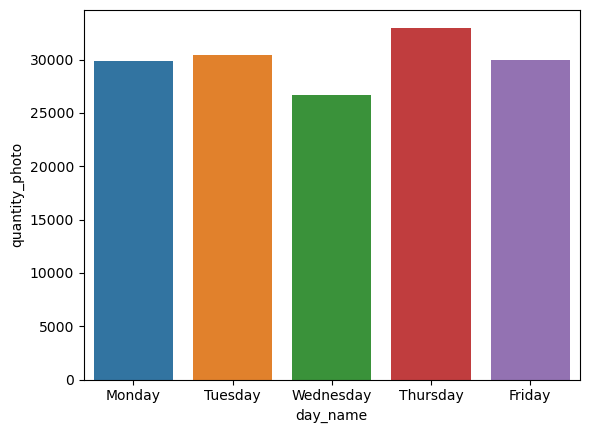

In [32]:
sns.barplot(x="day_name", y="quantity_photo", data=df_2, order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"])

Принципиальной разницы по дням недели нет.

Посмотрим на самые сканируемые категории продуктов.

In [33]:
df.groupby("prod_cat_name", as_index = False) \
  .agg({"dt_create": "count"}) \
  .sort_values("dt_create", ascending=False) \
  .rename(columns = {'dt_create':'quantity_photo'})

,prod_cat_name,quantity_photo
1,алкоголь,69424
4,продукты,44200
3,пиво,35837
2,нон-фуд,266
5,сигареты,177
6,товары для мониторинга,70
0,rrp и атп,26


Есть сильное смещение в топ-3 категорий, где катеория "алкоголь" сильно популярнее, чем другие. Что и не удивительно.

### Описательная аналитика

Заведём колонку с булевыми значениями, где true  - все сканирования с совпавшими id товара

In [34]:
df["coincidence_prod"] = df.predicted_product_id == df.confirmed_product_id

Аналогично проделаем с ценниками

In [35]:
df["coincidence_price"] = df.predicted_product_price == df.confirmed_product_price

Примем за 1 - совпадения, за 0 - несовпадения

In [36]:
df = df.replace({'coincidence_prod' : { True : 1, False : 0}}, ) \
  .replace({'coincidence_price' : { True : 1, False : 0}})

Теперь складываем и видим три расклада: 0 - не совпало ни одно, 1 - совпало что-то одно, 2 - совпали оба критерия

In [37]:
df["coincidence_all"] = df.coincidence_price + df.coincidence_prod

Расклад "совпало что-то одно" не так интересен, потому что мы отдельно выводим успешные сканирования и цены, и продукта по отдельности. Т.о. принимаем за 1 случаи с совпадениями по двум критериям, а за 0 случаи без сопадений и случаи, где совпал один критерий.

In [38]:
df = df.replace({'coincidence_all' : { 2 : 1, 1: 0}})

Красота:

In [39]:
df.head()

,dt_create,shop_id,competitor_id,prod_cat_name,prod_group_name,predicted_product_id,predicted_product_price,confirmed_product_id,confirmed_product_price,day_name,coincidence_prod,coincidence_price,coincidence_all
0,2023-01-30,3505,1,алкоголь,"вина, винные напитки",9291.0,43999.0,9291,43999,Monday,1,1,1
1,2023-01-30,1843,21,алкоголь,слабоалкогольные напитки,2020719.0,6999.0,10653,6999,Monday,0,1,0
2,2023-01-30,966,0,алкоголь,"вина, винные напитки",9377.0,53999.0,9377,53999,Monday,1,1,1
3,2023-01-30,4468,1,алкоголь,"коньяк, арманьяк, бренди, кальвадос",10413.0,15999.0,10413,15999,Monday,1,1,1
4,2023-01-30,1843,21,алкоголь,водка,9814.0,32999.0,9814,32999,Monday,1,1,1


Теперь подготовим данные для вычисления метрик:

In [40]:
df_3 = df.groupby("competitor_id", as_index = False) \
  .agg({"shop_id": "count", "coincidence_prod": "sum", "coincidence_price": "sum", "coincidence_all": "sum"}) \
  .rename(columns = {'shop_id':'quantity_photo'})

Вычисляем метрики:

0. "coincidence_prod" - распознавание продукта: доля распознанных фото товаров
1. "coincidence_price" - распознавание цены: доля распознанных фото цены
2. "coincidence_all" - общее распознавание: доля распознанных фото и товаров, и ценников

In [41]:
df_3["coincidence_prod"] = round(df_3.coincidence_prod / df_3.quantity_photo, 2)
df_3["coincidence_price"] = round(df_3.coincidence_price / df_3.quantity_photo, 2)
df_3["coincidence_all"] = round(df_3.coincidence_all / df_3.quantity_photo, 2)

In [42]:
df_3.head()

,competitor_id,quantity_photo,coincidence_prod,coincidence_price,coincidence_all
0,0,41045,0.92,0.95,0.91
1,1,40729,0.94,0.96,0.92
2,2,26965,0.95,0.94,0.92
3,3,4335,0.95,0.83,0.80
4,4,3122,0.93,0.89,0.84


# Проверяем все следующие гипотезы:

# 1. Все конкуренты одинаково распознаются

Конкурентов с необольшим кол-вом сканирований можно не проверять, т.к. пара сканирований не будет показательной, например, у конкурента 376 было 1 сканирование, где совпали и цена и продукт. Для объективности возьмём тех конкурентов, где было от 100 сканирований.

In [43]:
df_3 = df_3.query("quantity_photo >= 100")

In [44]:
df_3.describe()

,competitor_id,quantity_photo,coincidence_prod,coincidence_price,coincidence_all
count,72.00000,72.000000,72.000000,72.000000,72.000000
mean,35.50000,2006.972222,0.880694,0.865694,0.807083
std,20.92845,7350.414148,0.086648,0.127498,0.132914
min,0.00000,104.000000,0.410000,0.210000,0.160000
25%,17.75000,166.750000,0.870000,0.830000,0.777500
50%,35.50000,272.500000,0.905000,0.910000,0.840000
75%,53.25000,596.750000,0.930000,0.942500,0.890000
max,71.00000,41045.000000,0.980000,0.970000,0.960000


Для метрики coincidence_prod среднее 88% совпадений, посмотрим кол-во конкурентов выше указанного порога: всего 47 конкурентов распознаются по продукту чаще среднего (для выборки из тех конкурентов, где было сделано 100+ фото)

In [45]:
df_3.query("coincidence_prod > 0.88").shape[0]

47

Построим таблицу и график рапределения кол-ва конкурентов по значениям метрики

In [46]:
df_4 = df_3.groupby("coincidence_prod", as_index = False) \
    .agg({"competitor_id": "count"}) \
    .rename(columns = {'competitor_id':'quantity_competitor'})
df_4

,coincidence_prod,quantity_competitor
0,0.41,1
1,0.66,2
2,0.69,1
3,0.76,1
4,0.77,1
5,0.78,2
6,0.79,1
7,0.81,1
8,0.82,2
9,0.84,1


<Axes: xlabel='coincidence_prod', ylabel='quantity_competitor'>

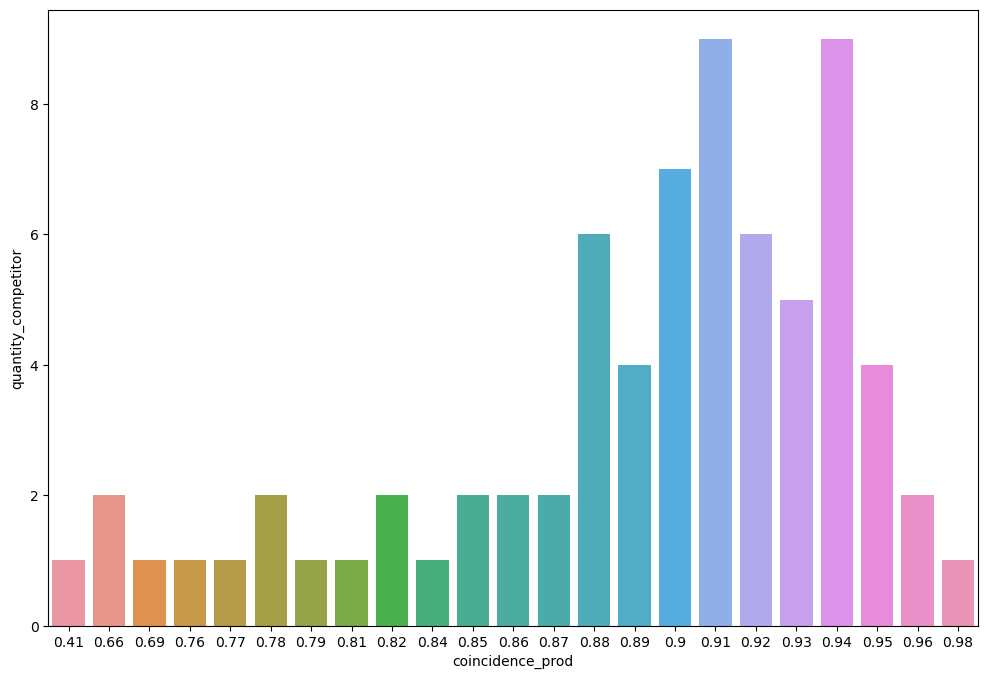

In [47]:
plt.figure(figsize=(12, 8))
sns.barplot(x="coincidence_prod", y="quantity_competitor", data=df_4)

И из таблицы, и из графика видно, что распознавание по продукту не одинаково, причём чем выше процент, тем больше соответсвующих ему конкурентов. При этом сам разбег по распознаванию в передлах 30%

Для метрики coincidence_price среднее 86% совпадений, посмотрим кол-во конкурентов выше указанного порога, всего 51 конкурент распознаётся по продукту чаще среднего (для выборки из тех конкурентов, где было сделано 100+ фото)

In [48]:
df_3.query("coincidence_price > 0.86").shape[0]

51

Построим таблицу и график рапределения кол-ва конкурентов по значениям метрики

In [49]:
df_5 = df_3.groupby("coincidence_price", as_index = False) \
    .agg({"competitor_id": "count"}) \
    .rename(columns = {'competitor_id':'quantity_competitor'})
df_5

,coincidence_price,quantity_competitor
0,0.21,1
1,0.51,1
2,0.55,2
3,0.68,1
4,0.72,2
5,0.74,2
6,0.75,1
7,0.77,2
8,0.79,1
9,0.80,3


<Axes: xlabel='coincidence_price', ylabel='quantity_competitor'>

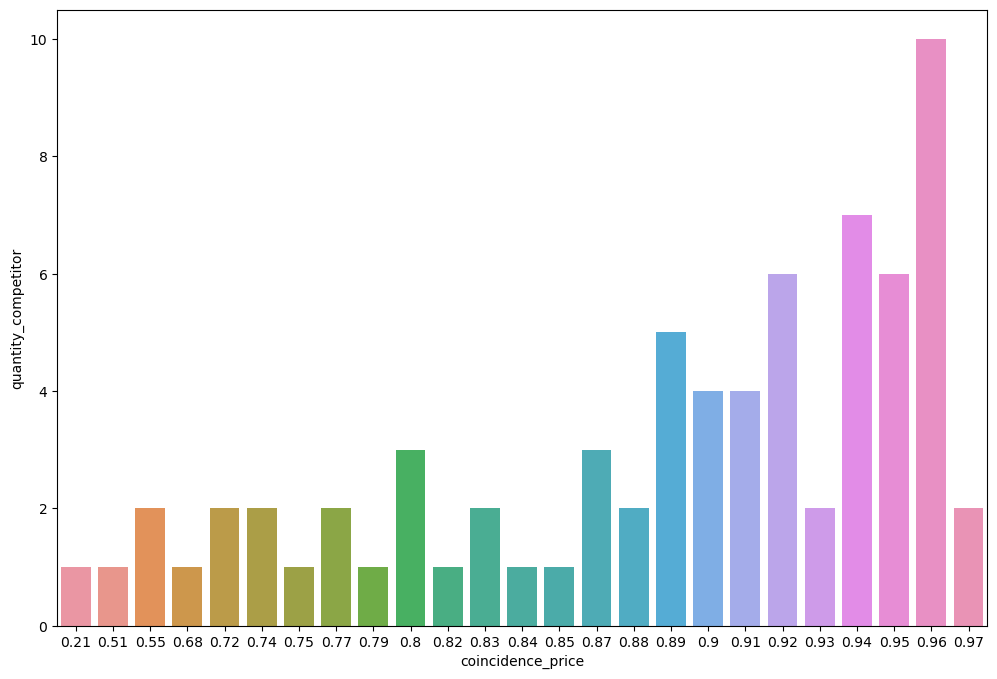

In [50]:
plt.figure(figsize=(12, 8))
sns.barplot(x="coincidence_price", y="quantity_competitor", data=df_5)

И из таблицы, и из графика также видно, что распознавание по цене не одинаково, причём чем выше процент тем больше соответсвующих ему конкурентов. При этом сам разбег по распознаванию цены более выражен, чем по распознованию продукта.

Для метрики coincidence_all среднее 80% совпадений, посмотрим кол-во конкурентов выше указанного порога, всего 48 конкурентов распознаются по продукту чаще среднего (для выборки из тех конкурентов, где было сделано 100+ фото).

In [51]:
df_3.query("coincidence_all > 0.8").shape[0]

48

Построим таблицу и график рапределения кол-ва конкурентов по значениям метрики:

In [52]:
df_6 = df_3.groupby("coincidence_all", as_index = False) \
    .agg({"competitor_id": "count"}) \
    .rename(columns = {'competitor_id':'quantity_competitor'})
df_6

,coincidence_all,quantity_competitor
0,0.16,1
1,0.43,1
2,0.51,1
3,0.52,1
4,0.59,1
5,0.61,1
6,0.62,1
7,0.63,1
8,0.68,2
9,0.69,1


<Axes: xlabel='coincidence_all', ylabel='quantity_competitor'>

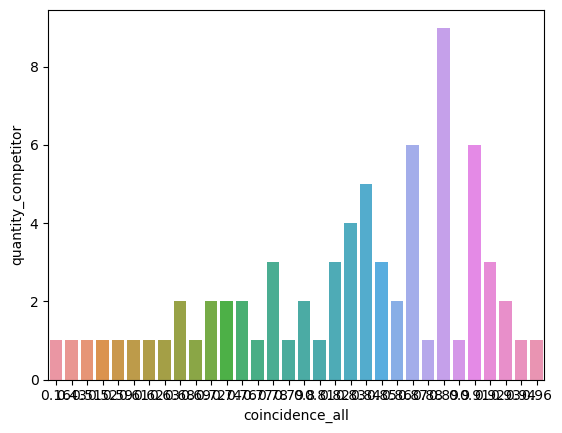

In [53]:
sns.barplot(x="coincidence_all", y="quantity_competitor", data=df_6)

И из таблицы, и из графика видно, что общее распознавание не одинаково, причём чем выше процент тем больше соответсвующих ему конкурентов. При этом распределение по общему распознаванию близко к распределению распознавания цены продукта.

Полагаю, что гипотеза неверна, и конкуренты распознаются по-разному.

Почему: одна из возможных причин - ценник, на них могут использоваться разные шрифты, вид бумаги, способ печати, м.б. использованы разные цвета (например при акции - жёлтые и красные ценники), разное кол-во информации, в т.ч. числовая, которая м.б. распознана как цена (артикул и т.п.)

Ещё возможная причина - то, как расположен товар и освещение: м.б. снижена читаемость ценников из-за тёного помещения, тесного расположения ценников, вожможно ценники ламинируются и отбликивают, что также влияет на их читаемость.

# 2. В распознавании цены есть проблемы

Во-первых, проверим, сколько раз цена вообще не распознана:

In [54]:
df.predicted_product_price.isna().sum()

3961

В 2,6% случаев цена небыла распознана совсем

In [55]:
df.predicted_product_price.isna().sum()/df.shape[0]

0.026406666666666665

Проверим, сколько раз цена не совпала с указанной в ценнике

In [56]:
df.shape[0] - df.coincidence_price.sum()

10303

Почти в 7% случаев цена не была распознана или распознана некорректно

In [57]:
(df.shape[0] - df.coincidence_price.sum())/df.shape[0]

0.06868666666666666

Посчитаем тоже с определением продукта:

In [58]:
df.predicted_product_id.isna().sum()/df.shape[0]

0.02596

In [59]:
(df.shape[0] - df.coincidence_prod.sum())/df.shape[0]

0.07406666666666667

Получаем примерно те же значения.

Ярко выраженной проблемы с определением цены не наблюдается как в части соотношения общего количества сканирований и количества неудачных сканировний, так и в соотношении неудачных сканирований цены и неудачных сканирований продукта. Гипотеза неверна.

# 3. Поле dt_create влияет на общую метрику распознавания

Пересчитаем метрику с группировкой по дате

In [60]:
df_7 = df.groupby("dt_create", as_index = False) \
  .agg({"shop_id": "count", "coincidence_all": "sum"}) \
  .rename(columns = {'shop_id':'quantity_photo'})

In [61]:
df_7["coincidence_all"] = round(df_7.coincidence_all / df_7.quantity_photo, 2)

In [62]:
df_7

,dt_create,quantity_photo,coincidence_all
0,2023-01-30,10028,0.87
1,2023-01-31,10383,0.87
2,2023-02-01,9039,0.86
3,2023-02-02,11050,0.91
4,2023-02-03,10039,0.88
5,2023-02-06,9935,0.88
6,2023-02-07,10002,0.90
7,2023-02-08,8867,0.86
8,2023-02-09,10940,0.91
9,2023-02-10,10009,0.88


In [63]:
df_7.coincidence_all.min()

0.86

In [64]:
df_7.coincidence_all.max()

0.92

По дате нет видимых отличий по кол-ву сканирований товара, также метрика coincidence_all колеблется от 86 до 92 процентов, что в общей картине также не играет роли. Гипотеза неверна.

Почему? Вероятно, магазины конкурентов посещяются равномерно, в каждый день совершается +/- одинаковое количество сканирований, также в выгрузке отсутствуют выходные, когда картина м.б. иной (например, из-за перегруженности сети, что затруднило бы попытки сделать качественное фото)

# 4. Общая метрика распознавания зависит от магазина сотрудника

In [65]:
df_8 = df.groupby("shop_id", as_index = False) \
  .agg({"dt_create": "count", "coincidence_all": "sum"}) \
  .rename(columns = {'dt_create':'quantity_photo'})

In [66]:
df_8.describe()

,shop_id,quantity_photo,coincidence_all
count,5321.000000,5321.000000,5321.000000
mean,2660.000000,28.190190,25.085510
std,1536.184722,15.229828,14.046232
min,0.000000,1.000000,0.000000
25%,1330.000000,17.000000,15.000000
50%,2660.000000,27.000000,24.000000
75%,3990.000000,38.000000,34.000000
max,5320.000000,103.000000,94.000000


У нас есть магазины с 1 сканированием, что также влияет на метрику, следует оценивать магазины где, например, более 10 сканирований

In [67]:
df_8 = df_8.query("quantity_photo > 10")

Считаем метрику:

In [68]:
df_8["coincidence_all"] = round(df_8.coincidence_all / df_8.quantity_photo, 2)

Видно, что в части магазинов действительно западает распознование, например, распознавание менее 50% характеризует 43 магазина, тогда как распознавание от 50 и выше характеризует уже 4646 магазинов

In [69]:
df_8.query("coincidence_all < 0.50").shape[0]

43

In [70]:
df_8.query("coincidence_all >= 0.50").shape[0]

4646

В целом, небольшой вес от общего кол-ва магазинов. Но можно сделать вывод, что распознавание затруднено в конкретных магазинах. Гипотеза верна.

# Дополнительная задача

Составим список товаров для обучения в виде перечня product_id  
Принимаем за аксиому то, что нельзя брать в обучение все товары, так как модель начинает хуже распознавать

Проверим количество уникальных продуктов по id

In [71]:
df.confirmed_product_id.nunique()

1609

Также проверим количество и выведем уникальные продуктовые группы

In [72]:
df.prod_group_name.nunique()

36

In [73]:
df.prod_group_name.unique()

array(['вина, винные напитки', 'слабоалкогольные напитки',
       'коньяк, арманьяк, бренди, кальвадос', 'водка',
       'игристые вина, напитки и шампанское', 'напитки безалкогольные',
       'пиво лицензионное', 'снэки', 'виски, висковые напитки, бурбоны',
       'настойки, наливки', 'кондитерские изделия',
       'аперитивы, бальзамы, вермуты, ликеры', 'бакалея', 'консервация',
       'пиво отечественное', 'молочные, кисломолочные продукты',
       'готовые блюда и кулинария', 'яйца',
       'ром, джин, текила и прочие крепкие напитки',
       'замороженная продукция', 'пиво импортное',
       'товары для персонального использования', 'сыры',
       'товары для животных', 'мясная гастрономия',
       'сезонный ассортимент', 'товары для мониторинга', 'сигареты',
       'нагреваемые табачные стики', 'девайсы многоразовые',
       'разливное пиво', 'свежие фрукты и овощи',
       'хлебобулочные изделия и выпечка', 'жевательная резинка',
       'антиполицай, антипохмелин', 'хоз.товары и

Дальше делаем тройную группировку от большего к меньшему: категория-группа-продукт и считаем количество фотографий для каждого продукта.
Для подсчёта метрики суммируем все совпадения по продукторым группам.
Также возьмём только те продукты, которые были сфотографированы не менее 10 раз, т.к. небольшое кол-во фотографий не может объективно отображать картину. Одна фотография по одному продукту даст или 100% или нулевой результат, в зависимости, что повлияет на наш выбор.

In [74]:
df_9 = df.groupby(["prod_cat_name", "prod_group_name", "confirmed_product_id"]) \
  .agg({"dt_create":"count", "coincidence_prod": "sum"}) \
  .sort_values(["prod_cat_name", "dt_create"]) \
  .rename(columns = {'dt_create':'quantity_photo'}) \
  .query("quantity_photo >= 10")

Считаем метрику как отношение всех фотографий к успешно-распознанным, чтобы получить оценку в разрезе каждого продукта.

In [75]:
df_9["coincidence_prod"] = round(df_9.coincidence_prod / df_9.quantity_photo, 2)

Для обучения модели выбираем кейсы с самыми эффективными распознаваниями продуктов. При среднем в 91% отберём только те, которые распознаются с частотой от 95%. Т.о. получим самые успешно обработанные фотографии продуктов.

In [76]:
df_9 = df_9.query("coincidence_prod >= 0.95")

Теперь можно выводить список id товаров, которые:

0. были достаточно часто сфотографированы, чтобы мы были уверены в том, что это не случайный результат
1. успешно распознавались не менее, чем в 95% случаев

In [77]:
list_product_id = df_9.reset_index().confirmed_product_id.to_list()

# SQL

In [78]:
from sqlalchemy import create_engine
engine = create_engine('sqlite://', echo=False)
df.to_sql('data', con=engine, index=False)

150000

In [115]:
sql_code = """
            
            
            SELECT *
            FROM data
              
              
        """
temp = pd.read_sql(sql_code, engine)
temp

,dt_create,shop_id,competitor_id,prod_cat_name,prod_group_name,predicted_product_id,predicted_product_price,confirmed_product_id,confirmed_product_price,day_name,coincidence_prod,coincidence_price,coincidence_all
0,2023-01-30 00:00:00.000000,3505,1,алкоголь,"вина, винные напитки",9291.0,43999.0,9291,43999,Monday,1,1,1
1,2023-01-30 00:00:00.000000,1843,21,алкоголь,слабоалкогольные напитки,2020719.0,6999.0,10653,6999,Monday,0,1,0
2,2023-01-30 00:00:00.000000,966,0,алкоголь,"вина, винные напитки",9377.0,53999.0,9377,53999,Monday,1,1,1
3,2023-01-30 00:00:00.000000,4468,1,алкоголь,"коньяк, арманьяк, бренди, кальвадос",10413.0,15999.0,10413,15999,Monday,1,1,1
4,2023-01-30 00:00:00.000000,1843,21,алкоголь,водка,9814.0,32999.0,9814,32999,Monday,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
149995,2023-02-17 00:00:00.000000,2159,0,продукты,напитки безалкогольные,2794367.0,10499.0,2794367,10499,Friday,1,1,1
149996,2023-02-17 00:00:00.000000,740,1,продукты,консервация,12071.0,17499.0,12071,17499,Friday,1,1,1
149997,2023-02-17 00:00:00.000000,217,0,пиво,пиво отечественное,10929.0,5699.0,10929,5699,Friday,1,1,1
149998,2023-02-17 00:00:00.000000,264,0,алкоголь,водка,9755.0,14499.0,9755,14499,Friday,1,1,1


### 1. Сколько всего уникальных магазинов, конкурентов и продуктов? 

In [80]:
sql_code = """
            
            
            SELECT COUNT(DISTINCT shop_id) AS quantity_shops, 
                   COUNT(DISTINCT competitor_id) AS quantity_competitors,
                   COUNT(DISTINCT confirmed_product_id) AS quantity_products
            FROM data
              
              
        """
temp = pd.read_sql(sql_code, engine)
temp

,quantity_shops,quantity_competitors,quantity_products
0,5321,380,1609


### 2. Выведем среднее количество строк по каждому дню недели в порядке убывания 

In [81]:
sql_code = """
            
            
            SELECT day_name, ROUND(AVG(quantity_lines), 2) AS avg_quantity
            FROM(
            SELECT day_name, COUNT(*) AS quantity_lines
            FROM data
            GROUP BY dt_create)
            GROUP BY day_name
            ORDER BY avg_quantity DESC
            

        """
temp = pd.read_sql(sql_code, engine)
temp

,day_name,avg_quantity
0,Thursday,11002.33
1,Tuesday,10148.67
2,Friday,9991.00
3,Monday,9962.33
4,Wednesday,8895.67


### 3. Какую категорию сотрудники магазинов фотографируют чаще всего?

In [82]:
sql_code = """
           
           
            SELECT prod_cat_name
            FROM data
            GROUP BY prod_cat_name
            ORDER BY COUNT(*) DESC
            LIMIT 1
            
              
        """
temp = pd.read_sql(sql_code, engine)
temp

,prod_cat_name
0,алкоголь


### 4. Какое среднее распознавание в топ-2 конкурентах?

In [83]:
sql_code = """
            
            
            SELECT competitor_id, coincidence_prod, coincidence_price, 
                   (coincidence_prod + coincidence_price)/2 AS avg_coincidence
            FROM
            (
            SELECT data_1.competitor_id, 
                   COALESCE(ROUND(CAST(coincidence_product_id AS FLOAT)/CAST(all_lines AS FLOAT), 2), 0) AS coincidence_prod,
                   COALESCE(ROUND(CAST(coincidence_product_price AS FLOAT)/CAST(all_lines AS FLOAT), 2), 0) AS coincidence_price
            FROM
            (
            SELECT competitor_id, COUNT(*) AS all_lines
            FROM data
            GROUP BY competitor_id
            ) AS data_1 LEFT JOIN
            (
            SELECT competitor_id, COUNT(*) AS coincidence_product_id
            FROM data
            WHERE predicted_product_id = confirmed_product_id
            GROUP BY competitor_id
            ) AS data_2
            ON data_1.competitor_id = data_2.competitor_id
            LEFT JOIN
            (
            SELECT competitor_id, COUNT(*) AS coincidence_product_price
            FROM data
            WHERE predicted_product_price = confirmed_product_price
            GROUP BY competitor_id
            ) AS data_3
            ON data_1.competitor_id = data_3.competitor_id
            ORDER BY all_lines DESC
            LIMIT 2
            )
            
              
        """
temp = pd.read_sql(sql_code, engine)
temp

,competitor_id,coincidence_prod,coincidence_price,avg_coincidence
0,0,0.92,0.95,0.935
1,1,0.94,0.96,0.950


### 5. Выведем топ-3 группы продуктов по количеству строк за каждый день недели

In [114]:
sql_code = """
            

            SELECT *
            FROM(
            SELECT STRFTIME('%w', dt_create) AS day, prod_group_name, COUNT(*) AS quantity_prod
            FROM data
            GROUP BY day, prod_group_name
            HAVING day = '1'
            ORDER BY COUNT(*) DESC
            LIMIT 3)
            
            UNION ALL
            
            SELECT *
            FROM(
            SELECT STRFTIME('%w', dt_create) AS day, prod_group_name, COUNT(*) AS quantity_prod
            FROM data
            GROUP BY day, prod_group_name
            HAVING day = '2'
            ORDER BY COUNT(*) DESC
            LIMIT 3)

            UNION ALL
            
            SELECT *
            FROM(
            SELECT STRFTIME('%w', dt_create) AS day, prod_group_name, COUNT(*) AS quantity_prod
            FROM data
            GROUP BY day, prod_group_name
            HAVING day = '3'
            ORDER BY COUNT(*) DESC
            LIMIT 3)
            
            UNION ALL
            
            SELECT *
            FROM(
            SELECT STRFTIME('%w', dt_create) AS day, prod_group_name, COUNT(*) AS quantity_prod
            FROM data
            GROUP BY day, prod_group_name
            HAVING day = '4'
            ORDER BY COUNT(*) DESC
            LIMIT 3)
            
            UNION ALL
            
            SELECT *
            FROM(
            SELECT STRFTIME('%w', dt_create) AS day, prod_group_name, COUNT(*) AS quantity_prod
            FROM data
            GROUP BY day, prod_group_name
            HAVING day = '5'
            ORDER BY COUNT(*) DESC
            LIMIT 3)

                
        """
temp = pd.read_sql(sql_code, engine)
temp

,day,prod_group_name,quantity_prod
0,1,водка,5585
1,1,пиво лицензионное,4244
2,1,кондитерские изделия,3071
3,2,водка,5719
4,2,пиво лицензионное,4389
5,2,кондитерские изделия,3079
6,3,водка,5399
7,3,пиво лицензионное,3938
8,3,напитки безалкогольные,2918
9,4,водка,5644


Решение через оконную функцию

In [111]:
sql_code = """
            
            
            WITH t_count AS
            (
                SELECT STRFTIME('%w', dt_create) AS day, 
                       prod_group_name, COUNT(*) AS quantity_prod
                FROM data
                GROUP BY day, 
                         prod_group_name
                ORDER BY COUNT(*) DESC
            )
            
            SELECT day,
                   prod_group_name
            FROM
            (
                SELECT *, ROW_NUMBER() OVER(PARTITION BY day) AS rownum
                FROM t_count
            )
            WHERE rownum <=3

            
        """
temp = pd.read_sql(sql_code, engine)
temp

,day,prod_group_name
0,1,водка
1,1,пиво лицензионное
2,1,кондитерские изделия
3,2,водка
4,2,пиво лицензионное
5,2,кондитерские изделия
6,3,водка
7,3,пиво лицензионное
8,3,напитки безалкогольные
9,4,водка
